# Part A: Linear Classification Models

### A1. Data Preparation

##### Import Needed Libraries

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

#### Read Dataset

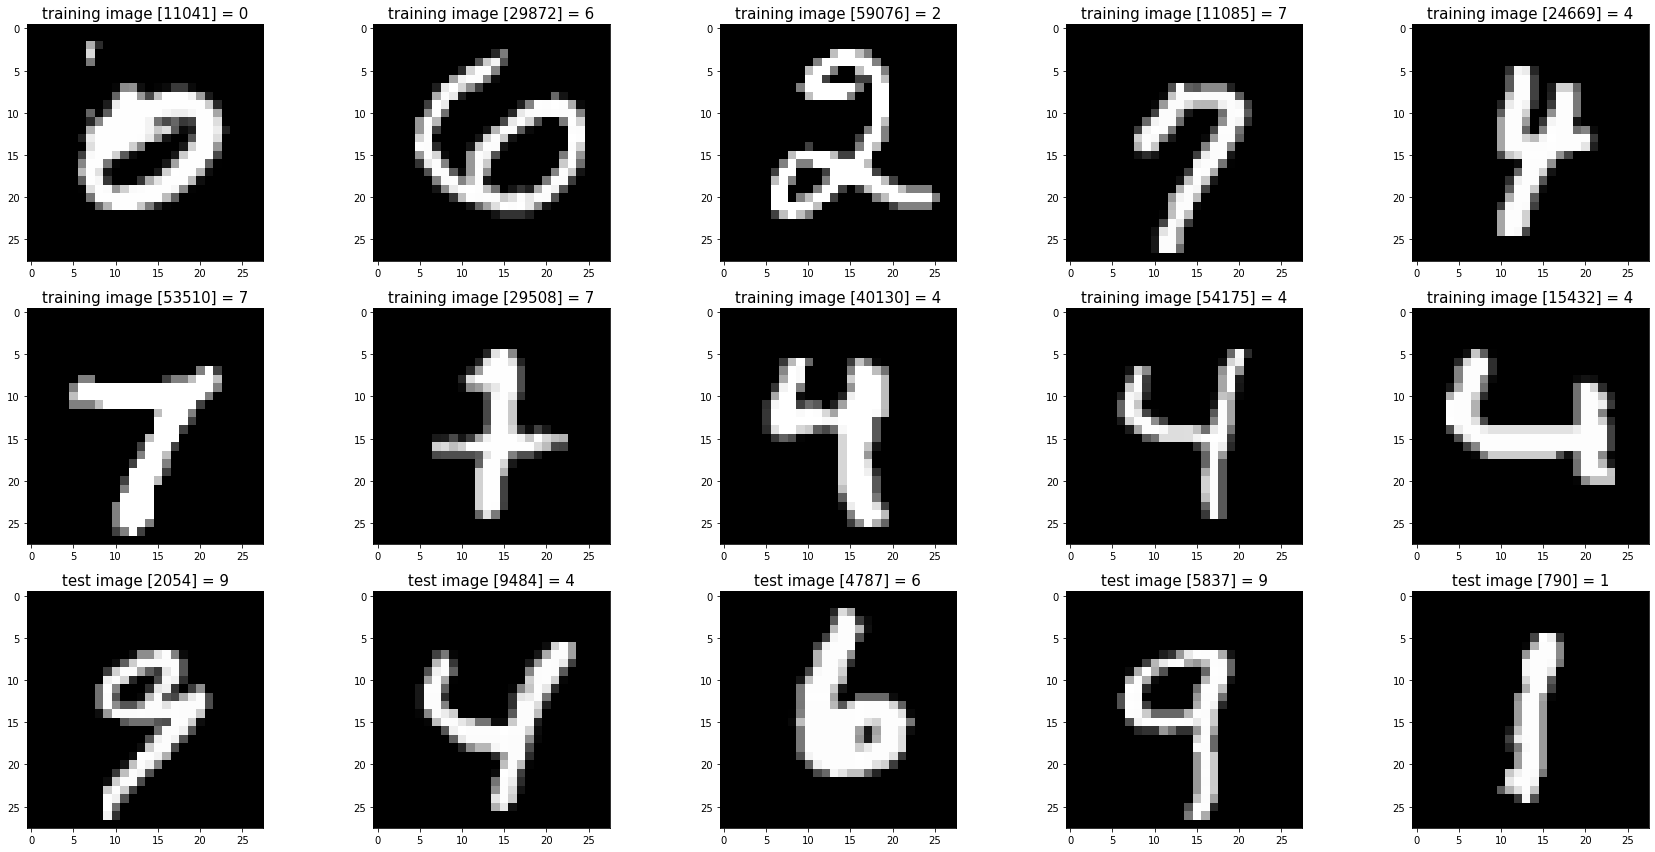

In [76]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'MNIST_Dataset'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)


#### Convert the data to numpy arrays

In [77]:
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int64)
y_test = np.array(y_test, dtype=np.int64)

#### Normalizing data to be in range [0, 1]

In [78]:
x_train /= 255.0
x_test /= 255.0

#### Combine and flatten data

In [79]:
X = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

X_flat = X.reshape(len(X), -1)  # (N, 784)


#### split data into training (60%), validation (20%), and test (20%) and flatten them

In [ ]:
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

X_train_flat = X_train_full.reshape(-1, 28*28)
X_val_flat = X_val.reshape(-1, 28*28)
X_test_flat = X_test.reshape(-1, 28*28)


#### Convert all to PyTorch tensors

In [82]:
X_train_img = torch.tensor(X_train_full).unsqueeze(1)  # (N, 1, 28, 28)
X_val_img = torch.tensor(X_val).unsqueeze(1)
X_test_img = torch.tensor(X_test).unsqueeze(1)

X_train_flat = torch.tensor(X_train_flat)
X_val_flat = torch.tensor(X_val_flat)
X_test_flat = torch.tensor(X_test_flat)

y_train_t = torch.tensor(y_train_full)
y_val_t = torch.tensor(y_val)
y_test_t = torch.tensor(y_test)

#### Create TensorDatasets

In [83]:
train_dataset_img = TensorDataset(X_train_img, y_train_t)
val_dataset_img = TensorDataset(X_val_img, y_val_t)
test_dataset_img = TensorDataset(X_test_img, y_test_t)

train_dataset_flat = TensorDataset(X_train_flat, y_train_t)
val_dataset_flat = TensorDataset(X_val_flat, y_val_t)
test_dataset_flat = TensorDataset(X_test_flat, y_test_t)

#### Create DataLoaders

In [84]:
train_loader_img = DataLoader(train_dataset_img, batch_size=64, shuffle=True)
val_loader_img = DataLoader(val_dataset_img, batch_size=64, shuffle=False)
test_loader_img = DataLoader(test_dataset_img, batch_size=64, shuffle=False)

train_loader_flat = DataLoader(train_dataset_flat, batch_size=64, shuffle=True)
val_loader_flat = DataLoader(val_dataset_flat, batch_size=64, shuffle=False)
test_loader_flat = DataLoader(test_dataset_flat, batch_size=64, shuffle=False)

#### Verify Data Preparation

In [90]:
print(f"Train: {len(train_dataset_img)}, Val: {len(val_dataset_img)}, Test: {len(test_dataset_img)}")
print("Example batch:")
batch_imgs, batch_labels = next(iter(train_loader_img))
print(batch_imgs.shape, batch_labels.shape)

Train: 42000, Val: 14000, Test: 14000
Example batch:
torch.Size([64, 1, 28, 28]) torch.Size([64])
